Members:


* Chetan Kalia 
* Ishaan Bhatt
* Chandana Sathish
* Jenna Hirji

# Introduction

We chose to investigate the classification of Amazon reviews of electronics products using machine learning techniques. The classification of customer reviews is a significant practical issue with numerous potential applications in business and industry. (Pang & Lee, 2008). Amazon, as one of the largest online retailers, can benefit from customer review classification to gain insights into the strengths and weaknesses of their products, identify common issues and complaints, and take corrective measures to improve their products. While we are not pursuing sentiment analysis specifically, the outcome variable predicted would allow us to infer sentiment. (details in the Machine Learning Overview). As a result, the focus of our problem is adjacent and yields a value similar to that described by Pang and Lee.

Customer review analysis utilizing machine learning techniques such as deep learning can provide useful insights into customer preferences and behavior. (Li et al., 2019). Businesses can gain valuable insights into customer feedback and take action to improve their products by accurately categorizing the reviews, while researchers and academics can use the information to study consumer behavior and preferences. Furthermore, online product review platforms are a data-rich source of information that could aid in the design of new products and improve their chances of market success due to a better understanding of market needs. (Singh & Tucker, 2017).

One novel use of machine learning to classify product reviews is to incorporate a better understanding of customer preferences into a recommendation system. Traditional recommendation systems frequently rely on user ratings or purchase history to make personalized recommendations, but these systems may fail to account for the nuances of user preferences and may fail to provide recommendations that are appropriate for the user's taste. By incorporating insights from customer reviews into a recommendation system, the system can better understand a user's preferences and make recommendations that the user is more likely to accept. For example, the system could classify the sentiment of a user's recent reviews and use that data to make personalized recommendations that are tailored to the user's preferences. There is ongoing research in this area, and there are some examples of this approach being used in practice. Amazon's recommendation system, for example, uses review sentiment analysis and customer rating analysis to help personalize product recommendations for customers. (Zhang et al., 2017). This novel approach to recommendation systems has the potential to improve the effectiveness and accuracy of personalized product recommendations significantly.

Overall, our aim is to create a machine learning model that predict the rating a user would give to an electronic product sold on Amazon based on the review they leave.


# Data Description

## Introduction to dataset 

Our dataset includes a subset of reviews by Amazon customers for electronics products. The dataset can be found in the “‘Small’ subsets for experimentation” section under the “Files” section at the following web address:
https://nijianmo.github.io/amazon/index.html?fbclid=IwAR0_5K7tu7q-ROrBlvDceA1KFPrasHFZWx7X-IfeTgG2ZQ9WcA11pH8JEjo#subsets. More specifically, the dataset is available as a compressed json file accessed by clicking the “reviews” hyperlink in the “Electronics” category. This dataset has a size of 1.16 GB and contains 6,739,590 reviews for electronic products.

Here, we can see the structure of the original dataset. We can also see an overview of the type and description for each column.

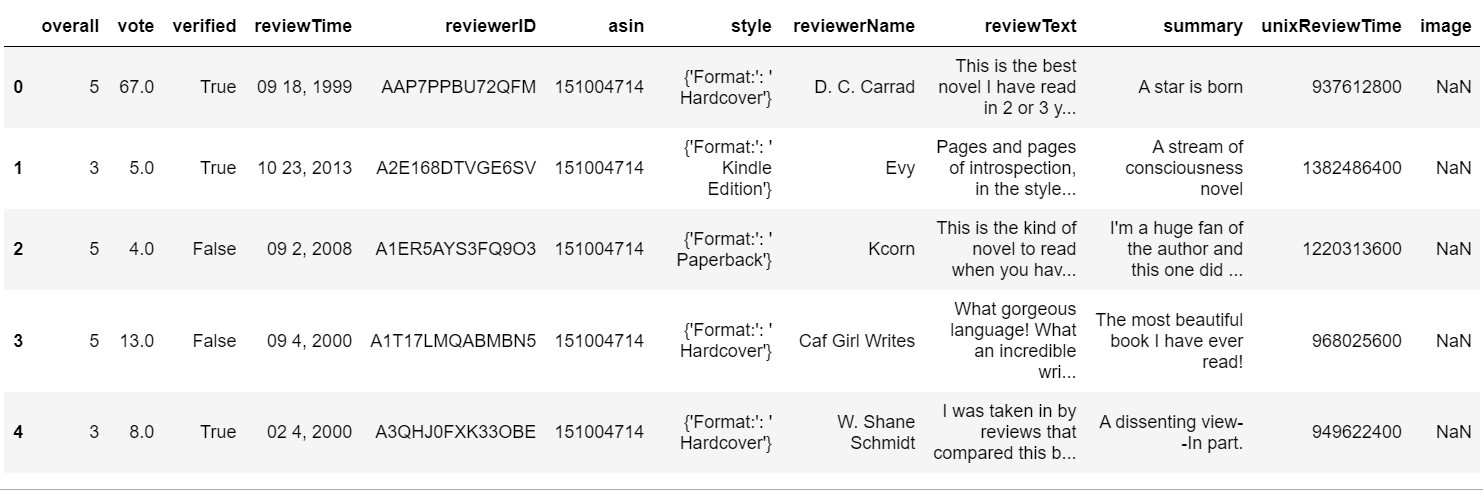

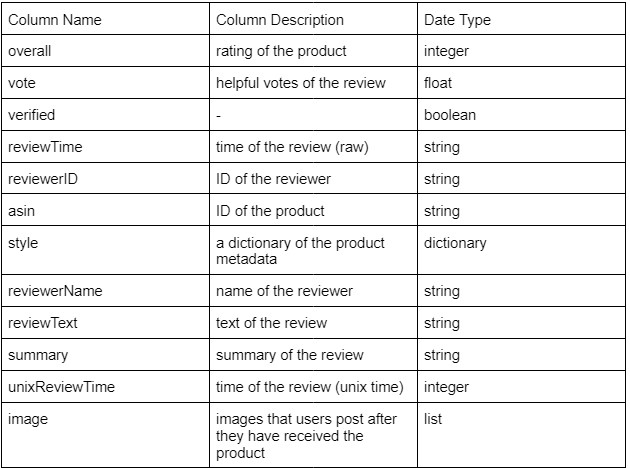



## Obtaining Data

Our original dataset is available as a compressed json file. We found that we couldn't read all the data into a dataframe because the file was likely corrupted. As a solution, we read chunks of the file into multiple dataframes and concatenated them into a single dataframe. 

Additionally, we found that some chunks had missing features. This is likely why we weren't able to read all the data at once. Therefore, in this step, we removed all features from each chunk before concatenating, except `overall`, `reviewText`, and `summary`. The remaining features are not important for our analysis. 

We also decided that we are more interested in being able to classify positive and negative reviews rather than neutral reviews. This is because businesses are generally more interested in addressing the concerns of customers unsatisifed with a product, or responding to customers who are satisifed with a product, to retain customers or show their appreciation respectively. Therefore, we want our model to be able to predict both positive and negative reviews well. As such, we chose to read in chunks until we had atleast 50,000 positive and negative reviews each. A positive review is defined as a review with a rating of 4.0 or 5.0, and a negative review is a defined as a review with a rating of 1.0 or 2.0.

In [49]:
import pandas as pd
import gzip
import json

chunks = pd.read_json("Electronics.json.gz", lines=True, chunksize = 100000)
dfs = []
count = 0
for chunk in chunks:
    dfs.append(chunk)
    count += 1
    if count == 5:
      break

# remove unimportant features
for i, df in enumerate(dfs):
  u_df = df[['overall', 'reviewText', 'summary']]
  dfs[i] = u_df

df_concat = pd.DataFrame({'overall': [], 'reviewText': [], 'summary': []})

for df in dfs:
  df_concat = pd.concat([df_concat, df])

df_concat.reset_index(inplace=True, drop=True)

negative_ratings = (df_concat['overall'] == 2.0).value_counts()[True] + (df_concat['overall'] == 1.0).value_counts()[True]
positive_ratings = (df_concat['overall'] == 4.0).value_counts()[True] + (df_concat['overall'] == 5.0).value_counts()[True]

print("negative ratings: ", negative_ratings)
print("positive ratings: ", positive_ratings)

df_concat.to_pickle("./data.pkl")
  

negative ratings:  51662
positive ratings:  412373


Since we are only interested in classifying positive and negative reviews, we chose to not consider reviews with a rating of 3.0, which signifiies a neutral rating. Therefore, in this step, we removed all reviews with a rating of 3.0. Additionally, we further condensed the dataset from the previous step to 1200 reviews, such that there are 300 reviews for each rating/class. While more data would likely improve our model, we found it took too long to run our code. 

In [50]:
import pickle
import pandas as pd
import numpy as np
df = pd.read_pickle("./data.pkl")
df = df[df["overall"]!=3.0] # remove rating 3 as it is neutral

data = pd.DataFrame({'overall': [], 'reviewText': [], 'summary': []})
data = pd.concat([data, df[df['overall']==1.0][:300]])
data = pd.concat([data, df[df['overall']==2.0][:300]])
data = pd.concat([data, df[df['overall']==4.0][:300]])
data = pd.concat([data, df[df['overall']==5.0][:300]])
data = data.reset_index(drop=True)
data.head()

,overall,reviewText,summary
0,1.0,Volume buttons were dead on arrival. be aware ...,One Star
1,1.0,Works great when I tape up the plug to the po...,plug falls out
2,1.0,Did not work. I'm sure the seller knew this be...,Do not buy!
3,1.0,I've had mine for a year and here's what we go...,"Major issues, only excuses for support"
4,1.0,real garbage don't wast your money,One Star


## Summary Statistics


In this section, we first check the distribution of the target class. As we expect, each class has about 300 reviews. We also check how many null values are in the dataset. Luckily, there are no null reviews, summaries, or ratings. Finally, we generate some basic information about the length of the reviews and summaries. On average, each review has 94 words. However, the standard deviation is large, indicating there are large differences in the length of the reviews. There are also no instances where the review is empty, as the lowest word count is 1. On average, each summary has 5 words. The low standard deviation indicates there are small differences in the length of the summaries. As with the reviews, the lowest word count is 1 for the summaries.

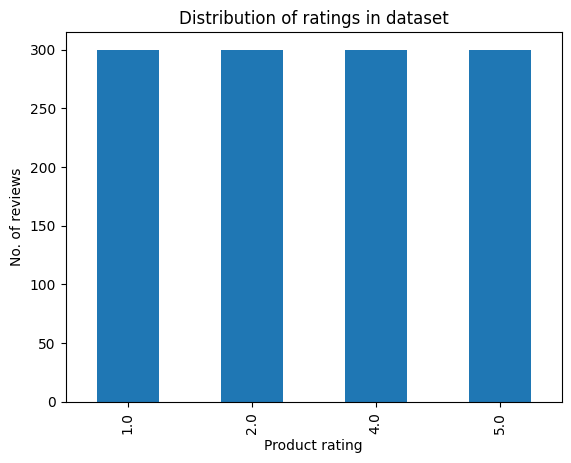

In [51]:
# count of classes in target variable
import matplotlib.pyplot as plt
plt.figure()
pd.value_counts(data['overall']).plot.bar(title="Distribution of ratings in dataset")
plt.xlabel("Product rating")
plt.ylabel("No. of reviews")
plt.show()

In [52]:
# number of missing data points
data.isnull().sum()

overall       0
reviewText    0
summary       0
dtype: int64

In [53]:
# average length of a review
data["length_review"] = data.dropna(subset=['reviewText']).reviewText.apply(lambda a: len(a.split(" ")))
describe_review_length = data["length_review"].describe()
describe_review_length

count    1200.000000
mean       94.040833
std       161.785366
min         1.000000
25%        16.000000
50%        40.000000
75%       106.000000
max      1869.000000
Name: length_review, dtype: float64

In [54]:
# average length of a summary
data["length_summary"] = data.dropna(subset=['summary']).summary.apply(lambda a: len(a.split(" ")))
describe_summary_length = data["length_summary"].describe()
describe_summary_length

count    1200.000000
mean        4.826667
std         3.655511
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        26.000000
Name: length_summary, dtype: float64

## Data Cleaning and Feature Engineering

In this step, we remove duplicate records using the `drop_duplicates` function that checks all fields in the dataset for duplicates.

In [55]:
# remove duplicate records
df_features = data
df_features.drop_duplicates(inplace=True)
df_features.shape

(1194, 5)

In this step, we combine the `reviewText` and `summary` features into a single `review` feature to reduce complexity. Specfically, we add a review to the `review` feature if atleast one of `reviewText` or `summary` features are not empty. If they are both empty then we drop the review. In this step, we also remove reviews with no rating, as they do not help us. 

In summary, this step includes feature engineering and data cleaning. We reduce complexity by reducing our dataset to one feature and remove instances when there is no review and summary. The code also handles the case when either or both of `reviewText` or `summary` features have null values.

In [56]:
# merge summary and reviewText into one feature and remove rows where they are both empty
# combine the two columns into a new column
df_features['review'] = df_features['reviewText'].fillna('') + df_features['summary'].fillna('')

# replace the review and rating columns with null values with NaN
df_features['review'].replace('', np.nan, inplace=True)

# remove rows with empty review or rating
df_features.dropna(subset=['review', 'overall'], inplace=True)

# remove reviewText and summary columns
df_features.drop(["reviewText", "summary"], axis=1, inplace=True)

# reset index after dropping rows
df_features.reset_index(drop=True, inplace=True)

# dimensions of data after dropping rows with null values
df_features.shape

(1194, 4)

In this step, we wrote a function that can clean the text passed in. Firstly, it uses regex to remove all non-word characters, non-whitespace characters, and digits. It then tokenizes the text. Each token is then lemmatized, expanded if it is a contraction, and lowercased. Additionally, stop words are removed and spell check is performed to remove words not part of the dictionary. We found spell check to drastically improve the results of our models.

As an aside, our preprocessing/cleaning process went through many iterations. We found that the below steps in the `clean` function did the best job at cleaning the data. Especially the spell check, as without it, there was a significant amount of words that were spelled incorrectly or instances where the users had forgotten to add a space between words.

In [57]:
# imports
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from textblob import TextBlob
from nltk.corpus import words
!pip install pyenchant
!apt-get install -y enchant
!pip install contractions
import contractions
import enchant

# download at the start of the session
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger')
nltk.download('words')


def clean(text):
  text = re.sub(r'[^\w\s]|[0-9]', '', text)  # remove all non-word characters, non-whitespace characters, and digits 
  lemmatizer = nltk.WordNetLemmatizer() 
  words = []
  for word, tag in pos_tag(word_tokenize(text)): # lemmatization
      wntag = tag[0].lower()
      wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
      if not wntag:
          lemma = word
      else:
          lemma = lemmatizer.lemmatize(word, wntag)
      words.append(lemma)          
  lower = [word.lower() for word in words] # remove capitals
  remove_stopwords = [word for word in lower if word not in stopwords.words('english')] # remove stopwords
  expand_contractions = [contractions.fix(word) for word in remove_stopwords]  # expand contractions
  d = enchant.Dict("en_US")
  spell_check = []
  for word in expand_contractions: 
        if d.check(word):  # spell check
            spell_check.append(word)
  return spell_check


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
enchant is already the newest version (1.6.0-11.3build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Initial Data Visualizations

The below code blocks showcase word clouds for each label based on the frequency of the words in the reviews that correspond to that label (done for ratings of 1, 2, 4, and 5).

For example, the code in the below block generates a word cloud for reviews with a 1-star rating, where it concatenates all the words in those reviews, creates a WordCloud object with specified dimensions, generates the word cloud based on the concatenated text, and displays the word cloud as an image.

For the 1.0 rating, we see words that we can expect when customers are dissatisifed, such as problem, cheap, and junk.

For the 5.0 rating, we see words that we can expect when customers are satisifed, such as great, love, and perfect.

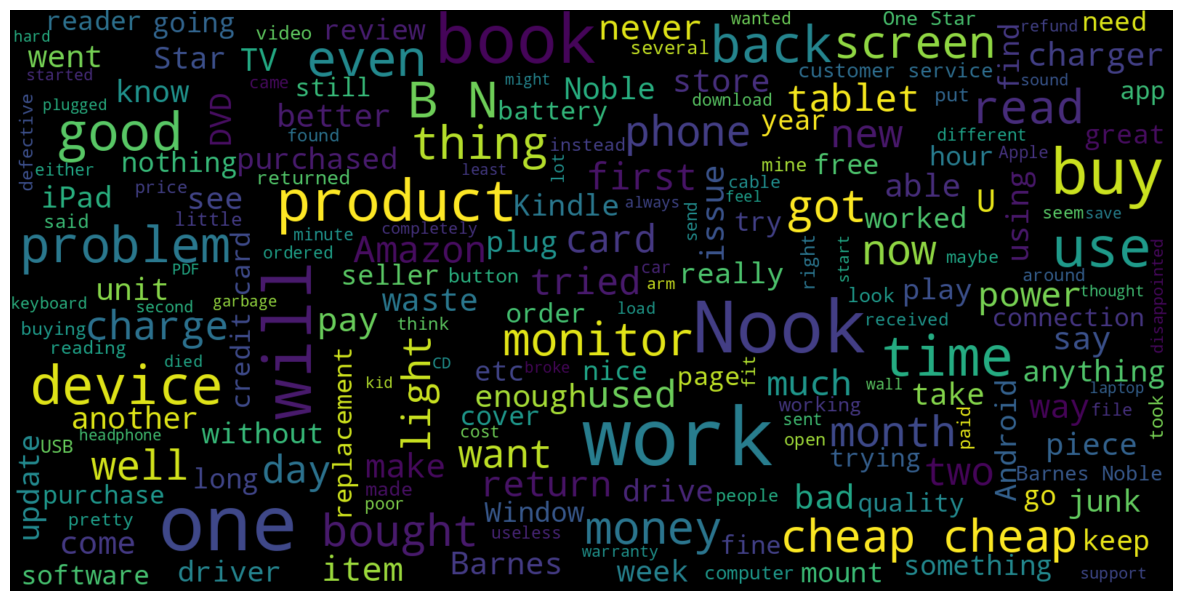

In [58]:
# word cloud for 1 star
from wordcloud import WordCloud

consolidated=' '.join(word for word in df_features['review'][data['overall']==1].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

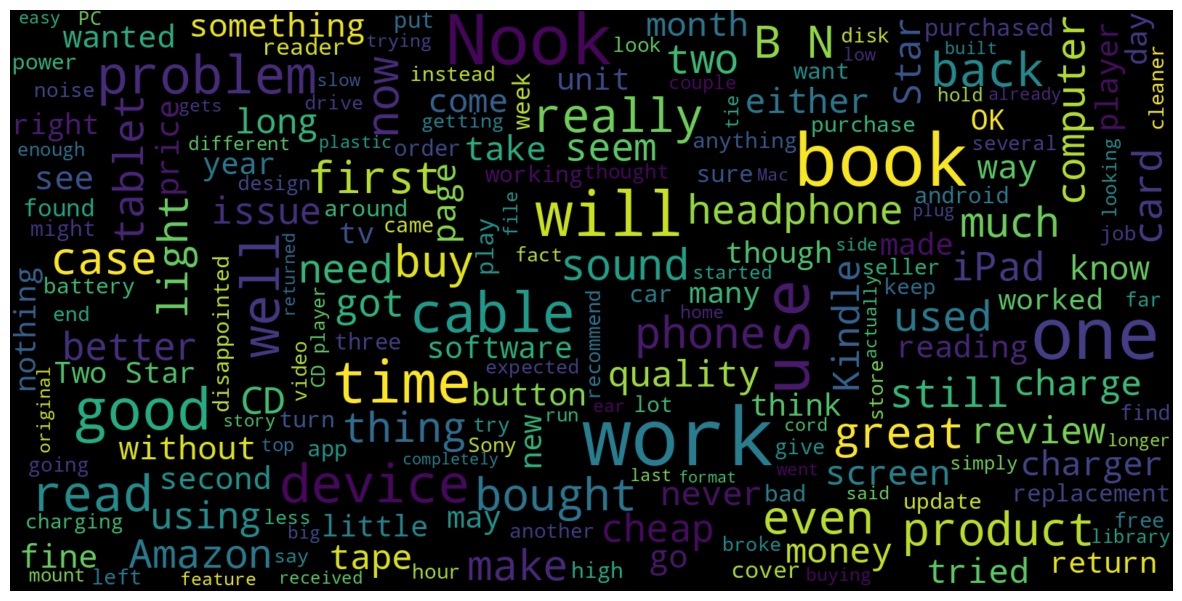

In [59]:
#data vizualization for 2 star
from wordcloud import WordCloud

consolidated=' '.join(word for word in df_features['review'][data['overall']==2].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

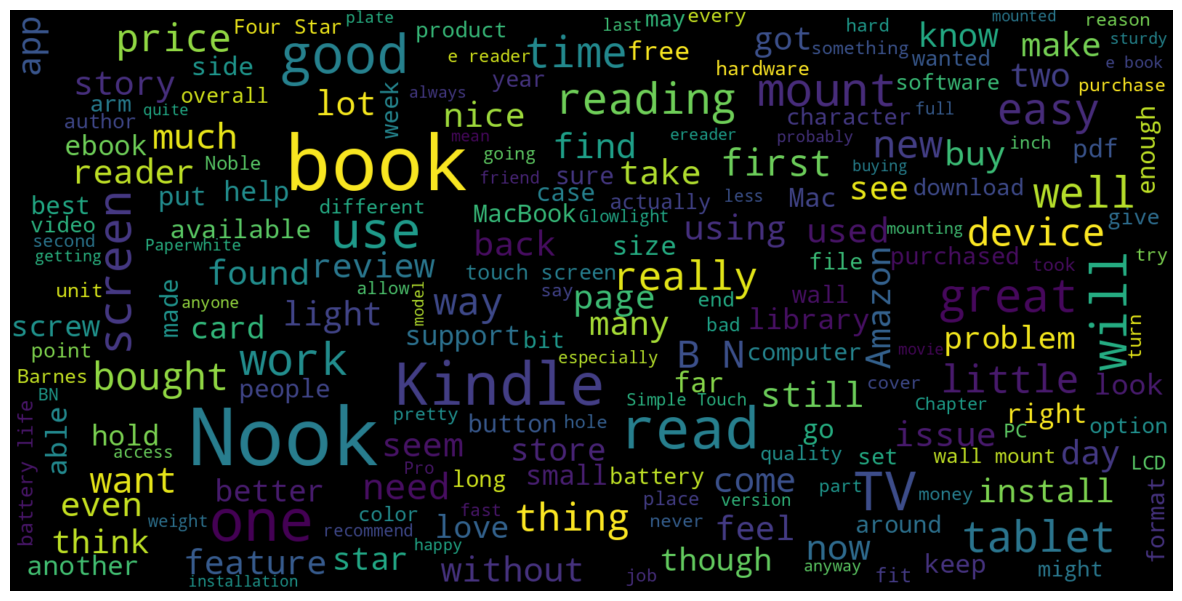

In [60]:
#data vizualization for 4 star
from wordcloud import WordCloud

consolidated=' '.join(word for word in df_features['review'][data['overall']==4].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

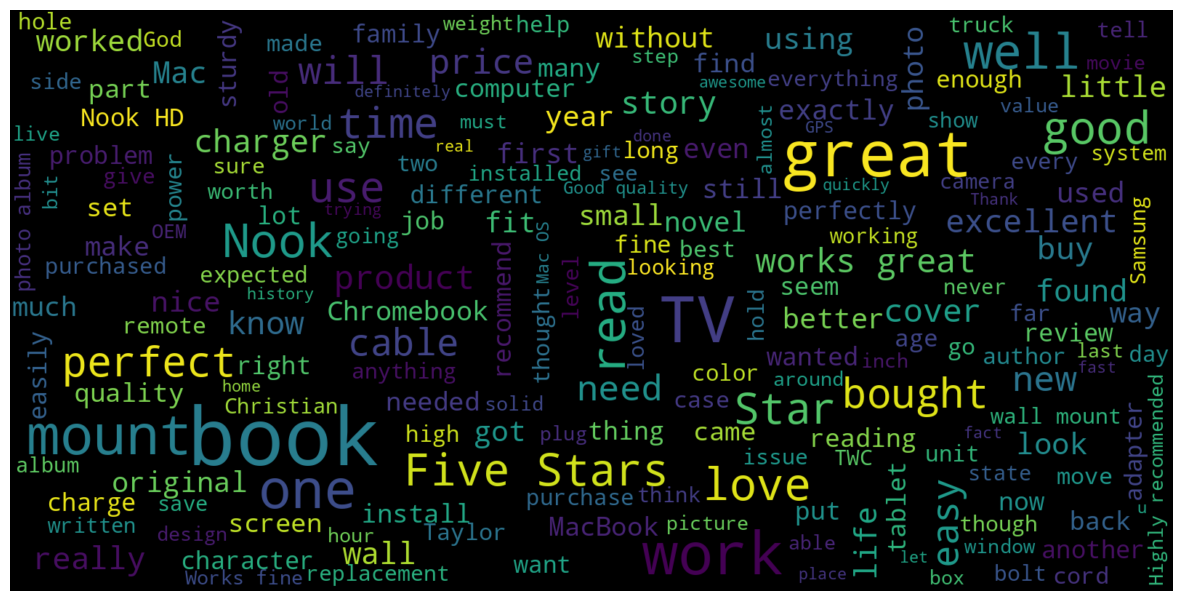

In [61]:
#data vizualization for 5 star
from wordcloud import WordCloud

consolidated=' '.join(word for word in df_features['review'][data['overall']==5].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Transformation and Analysis

In this step, we split our  dataset of approximately 1300 reviews into a training, validation, and test set. Specfically, we do a 80-20 train-test split on the dataset, and then a 75-25 train-validation split on the training dataset produced from the first split. In each split, we set the `stratify` paramater to try and get an equal distribution of classes in the datasets.

In [62]:
# train test split
from sklearn.model_selection import train_test_split

features = df_features.drop("overall",axis=1)
labels = df_features["overall"]

# 80 - 20 train test split
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size = 0.2, random_state=42, stratify=labels)

# 75 - 25 train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state=42, stratify=y_train_val)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 716 
- Validation: 239 
- Test: 239


In this step, we transformed our data into a format the machine learning models can understand. Specfically, we vectorized the reviews by scoring them using TF-IDF and created a document term matrix. We found TF-IDF to be the best scoring method because we want to give importance to words that appear many times in a review and less times across other reviews. We also passed in the `clean` function we defined earlier as an analyzer into the `TfidfVectorizer`.

In [63]:
# create document term matrix 
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
vectorizer = TfidfVectorizer(analyzer=clean)

def vectorize(data, tfidf_fit):
  X_tfidf = tfidf_fit.transform(data)
  words = tfidf_fit.get_feature_names_out()
  dtm = pd.DataFrame(X_tfidf.toarray())
  dtm.columns = words
  return dtm
tfidf_fit = vectorizer.fit(X_train['review'])
dtm_X_train = vectorize(X_train['review'], tfidf_fit)

Below, we can see all of the words in the document term matrix. Each word is represented as a column.

In [64]:
#dtm_X_train = pd.read_pickle("./dtm_X_train.pk1")
pd.set_option('display.max_columns', None)
dtm_X_train.head()

abandon  ability      able  abroad  absolute  absolutely  absurd  abused  \
0      0.0      0.0  0.000000     0.0       0.0         0.0     0.0     0.0   
1      0.0      0.0  0.000000     0.0       0.0         0.0     0.0     0.0   
2      0.0      0.0  0.000000     0.0       0.0         0.0     0.0     0.0   
3      0.0      0.0  0.034008     0.0       0.0         0.0     0.0     0.0   
4      0.0      0.0  0.000000     0.0       0.0         0.0     0.0     0.0   

   abysmal   ac  accept  acceptable  acceptance  access  accessible  \
0      0.0  0.0     0.0         0.0         0.0     0.0         0.0   
1      0.0  0.0     0.0         0.0         0.0     0.0         0.0   
2      0.0  0.0     0.0         0.0         0.0     0.0         0.0   
3      0.0  0.0     0.0         0.0         0.0     0.0         0.0   
4      0.0  0.0     0.0         0.0         0.0     0.0         0.0   

   accessory  accident  accidental  accidentally  acclimatize  accommodate  \
0   0.558931       0.0         0.0           0.0          0.0          0.0   
1   0.000000       0.0         0.0           0.0          0.0          0.0   
2   0.000000       0.0         0.0           0.0          0.0          0.0   
3   0.000000       0.0         0.0           0.0          0.0          0.0   
4   0.000000       0.0         0.0           0.0          0.0          0.0   

   accompany  accompanying  accomplish  accord  according  accordingly  \
0        0.0           0.0         0.0     0.0        0.0          0.0   
1        0.0           0.0         0.0     0.0        0.0          0.0   
2        0.0           0.0         0.0     0.0        0.0          0.0   
3        0.0           0.0         0.0     0.0        0.0          0.0   
4        0.0           0.0         0.0     0.0        0.0          0.0   

   account  accumulate  accumulation  accurate  accustom  accustomed  achieve  \
0      0.0         0.0           0.0       0.0       0.0         0.0      0.0   
1      0.0         0.0           0.0       0.0       0.0         0.0      0.0   
2      0.0         0.0           0.0       0.0       0.0         0.0      0.0   
3      0.0         0.0           0.0       0.0       0.0         0.0      0.0   
4      0.0         0.0           0.0       0.0       0.0         0.0      0.0   

   achievement  acknowledge  acknowledgment  acquaint  acquaintance  \
0          0.0          0.0             0.0       0.0           0.0   
1          0.0          0.0             0.0       0.0           0.0   
2          0.0          0.0             0.0       0.0           0.0   
3          0.0          0.0             0.0       0.0           0.0   
4          0.0          0.0             0.0       0.0           0.0   

   acquainted  across  act  action  activate  active  actively  activity  \
0         0.0     0.0  0.0     0.0       0.0     0.0       0.0       0.0   
1         0.0     0.0  0.0     0.0       0.0     0.0       0.0       0.0   
2         0.0     0.0  0.0     0.0       0.0     0.0       0.0       0.0   
3         0.0     0.0  0.0     0.0       0.0     0.0       0.0       0.0   
4         0.0     0.0  0.0     0.0       0.0     0.0       0.0       0.0   

   actual  actually   ad  adapt  adapter       add  added  addict  adding  \
0     0.0       0.0  0.0    0.0      0.0  0.000000    0.0     0.0     0.0   
1     0.0       0.0  0.0    0.0      0.0  0.000000    0.0     0.0     0.0   
2     0.0       0.0  0.0    0.0      0.0  0.000000    0.0     0.0     0.0   
3     0.0       0.0  0.0    0.0      0.0  0.037129    0.0     0.0     0.0   
4     0.0       0.0  0.0    0.0      0.0  0.000000    0.0     0.0     0.0   

   addition  additional  additionally  address  adequate  adjacent    adjust  \
0       0.0         0.0           0.0      0.0       0.0       0.0  0.000000   
1       0.0         0.0           0.0      0.0       0.0       0.0  0.000000   
2       0.0         0.0           0.0      0.0       0.0       0.0  0.000000   
3       0.0         0.0          

In this step, we sort the words by their TF-IDF scores and select the top 50 words. These words are the most discriminative i.e appear less but distinguish the reviews the best. As we might expect, words to express sentiment like good, great, and love are amongst those that can be used to distinguish reviews the best.

In [65]:
# Get the vocabulary (unique words) from the vectorizer
vocabulary = vectorizer.get_feature_names_out()

# Get the top 50 words by sorting the sum of the tf-idf scores across all documents
top_words = dtm_X_train.sum(axis=0).sort_values(ascending=False)[:50]

# Print the top 50 words
print(top_words.index)

Index(['stars', 'work', 'book', 'nook', 'get', 'use', 'buy', 'good', 'one',
       'great', 'mount', 'star', 'would', 'works', 'like', 'well', 'read',
       'cable', 'time', 'product', 'charge', 'charger', 'make', 'card',
       'little', 'need', 'try', 'love', 'easy', 'price', 'device', 'come',
       'go', 'look', 'purchase', 'fine', 'quality', 'even', 'find', 'phone',
       'screen', 'kindle', 'cheap', 'new', 'could', 'thing', 'want', 'nice',
       'much', 'really'],
      dtype='object')


In this step, we create a heatmap to show the co-occurance of words i.e. frequency of pairs of words in the reviews. We  select a subset of the top 50 words obtained from the previous step to display in the heatmap. Overall, we don't see a high correlation between the words.

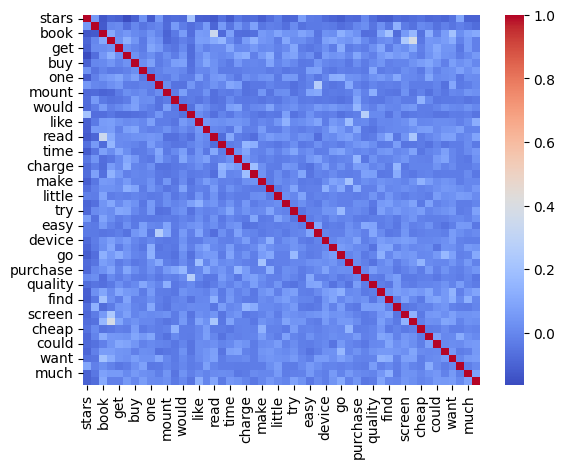

In [66]:
import seaborn as sns

subset_words = list(top_words.index)
dtm_X_train_subset = dtm_X_train[subset_words]
sns.heatmap(dtm_X_train_subset.corr(), cmap='coolwarm') # Create a heatmap of the co-occurrence of words
plt.show()

We can also see the top 20 words that appear the most frequntly in the reviews using the `CountVectorizer`

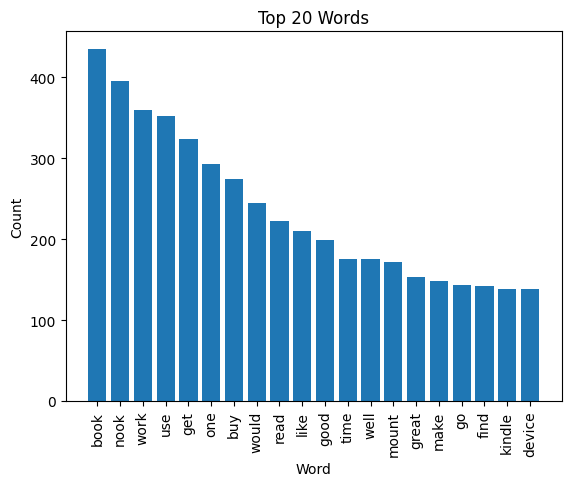

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer=clean)
X_count = count_vectorizer.fit_transform(X_train['review'])

vocabulary = count_vectorizer.get_feature_names_out()

dtm_X_train_count = pd.DataFrame(X_count.toarray(), columns=vocabulary)

# Get the count of each word across all documents
word_count = dtm_X_train_count.sum(axis=0)

# Get the top 20 words by count
top_words = word_count.nlargest(20)

plt.bar(top_words.index, top_words.values)

plt.title("Top 20 Words")
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90)

plt.show()

## Feature Selection

###### Chi-Square
The chi-square test is one method by which we have implemented feature engineering in our project. This test is a statistical method for determining the relationship between two categorical variables, in our case, the text words and the sentiment labels. The chi-square test computes the difference in frequency between the observed and expected frequency of each word in each sentiment class. Words with a high chi-square score are thought to be more important for classification.

Because it is effective at identifying important features in text data, the chi-square test is an excellent choice for feature engineering in our project. Words that appear frequently in one class but infrequently in the other are likely to be good indicators of emotion. The chi-square test is also simple to use and can be completed quickly, even for large datasets.

More formally, given a document  D, we estimate the following quantity for each term and rank them by their score:
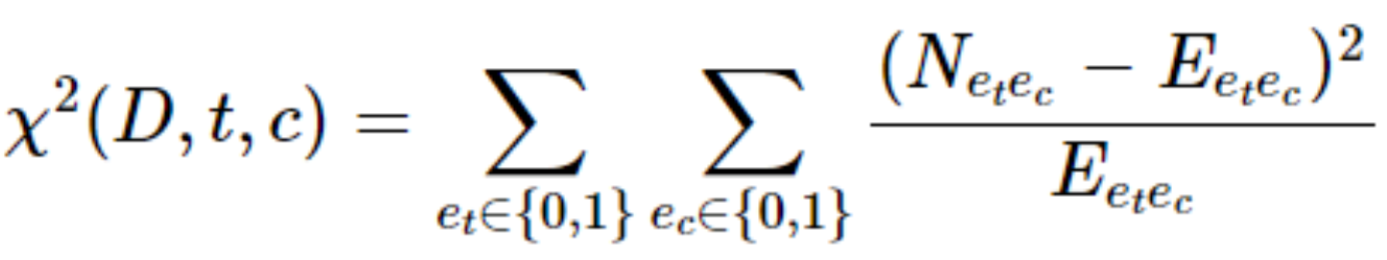

Where:
- N is the observed frequency in and E the expected frequency 
- e<sub>t</sub> takes the value 1 if the document contains term t and 0 otherwise
- e<sub>c</sub> takes the value 1 if the document is in class c and 0 otherwise

For each feature (term), a corresponding high χ2 score indicates that the null hypothesis H0 of independence (meaning the document class has no influence over the term's frequency) should be rejected and the occurrence of the term and class are dependent. In this case, we should select the feature for the text classification.

To perform the chi-square test, we first binarize the output column so that computing the observed value is as simple as a dot product. The observed count is then computed for each class and feature. The probability of each class and the number of features are also computed and saved as a two-dimensional array with reshape. The expected value of each word in each class, as well as the chi-square score for each word, are then computed. The SelectKBest method is used to choose the top K features based on the chi-square score.

In our project, we used the scikit-learn library's SelectKBest method to implement the chi-square test. We first specify the number of top features to be chosen, K, and then apply the SelectKBest method to the document term matrix (dtm) and the output labels Y. The selected feature indices and corresponding feature names are then extracted, yielding a list of the top K features based on the chi-square score.



In [68]:
# chi-square implementation
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import chi2, SelectKBest

Y = y_train

# binarize the output column,
# this makes computing the observed value a 
# simple dot product

y_binarized = LabelBinarizer().fit_transform(Y)
print(y_binarized)
print()

# our observed count for each class (the row)
# and each feature (the column)
observed = np.dot(y_binarized.T, dtm_X_train)
print(observed)

# compute the probability of each class and the feature count; 
# keep both as a 2 dimension array using reshape
class_prob = y_binarized.mean(axis = 0).reshape(1, -1)
feature_count = dtm_X_train.sum(axis = 0).values.reshape(1, -1)
expected = np.dot(class_prob.T, feature_count)
print(expected)

chisq = (observed - expected) ** 2 / expected
chisq_score = chisq.sum(axis = 0)
print(chisq_score)

chi2score = chi2(dtm_X_train, Y)
chi2score

[[0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]]

[[0.         0.03424133 1.5502283  ... 0.02420846 0.         0.09164112]
 [0.         0.43714888 0.35216205 ... 0.         0.         0.        ]
 [0.         1.17770744 1.31992179 ... 0.         0.09225515 0.22743381]
 [0.09922716 0.         0.68114235 ... 0.         0.         0.        ]]
[[0.02480679 0.41227441 0.97586362 ... 0.00605212 0.02306379 0.07976873]
 [0.02494537 0.41457762 0.98131537 ... 0.00608593 0.02319264 0.08021437]
 [0.02480679 0.41227441 0.97586362 ... 0.00605212 0.02306379 0.07976873]
 [0.0246682  0.4099712  0.97041187 ... 0.0060183  0.02293494 0.0793231 ]]
[0.29991129 2.17894677 0.94895698 ... 0.07262539 0.27676545 0.4346569 ]


(array([0.29991129, 2.17894677, 0.94895698, ..., 0.07262539, 0.27676545,
        0.4346569 ]),
 array([0.96004516, 0.5361071 , 0.81360012, ..., 0.99490659, 0.96433735,
        0.93299371]))

In [69]:
# top features for each class label

# Define the number of top features to select
K = 500

# Create an empty dictionary to store the top features for each class label
top_features = {}

# Loop over each class label
for label in range(1, 6):
    
    # Create a boolean mask for the current class label
    label_mask = (Y == label)
    
    # Compute the chi-squared scores for all features
    chi2score, _ = chi2(dtm_X_train, label_mask)
    
    # Sort the scores in descending order
    sorted_indices = np.argsort(chi2score)[::-1]
    
    # Get the indices of the top K features
    top_k_indices = sorted_indices[:K]
    
    # Get the corresponding feature names
    feature_names = vectorizer.get_feature_names_out()
    top_k_features = [feature_names[idx] for idx in top_k_indices]
    
    # Add the top features to the dictionary
    top_features[label] = top_k_features[:25]

# Print the top features for each class label
for label, features in top_features.items():
    print(f'Top 25 features for rating {label}: {features}')

Top 25 features for rating 1: ['star', 'stars', 'waste', 'driver', 'plug', 'garbage', 'great', 'pay', 'fail', 'junk', 'cheap', 'lg', 'money', 'poor', 'works', 'burn', 'cheaply', 'return', 'work', 'mount', 'working', 'crap', 'render', 'got', 'port']
Top 25 features for rating 2: ['tape', 'cleaner', 'mount', 'deck', 'works', 'player', 'sound', 'stop', 'radio', 'tie', 'stereo', 'cable', 'mic', 'star', 'track', 'clean', 'function', 'data', 'noise', 'skip', 'auto', 'headphone', 'print', 'bulky', 'record']
Top 25 features for rating 3: ['zoom', 'fight', 'fingerprint', 'finger', 'fine', 'finding', 'finder', 'find', 'finally', 'finagle', 'film', 'fill', 'file', 'figured', 'figure', 'fifth', 'extendable', 'fiddle', 'fictional', 'fiction', 'fewer', 'female', 'felt', 'fellow', 'fella']
Top 25 features for rating 4: ['mount', 'kindle', 'adjust', 'screw', 'plate', 'smaller', 'flexibility', 'book', 'breeze', 'charger', 'library', 'model', 'tilt', 'bolt', 'wife', 'wall', 'read', 'overall', 'touchscre

Here we create plots of the frequency of the top 25 words per label based on the output of the chi squared method.

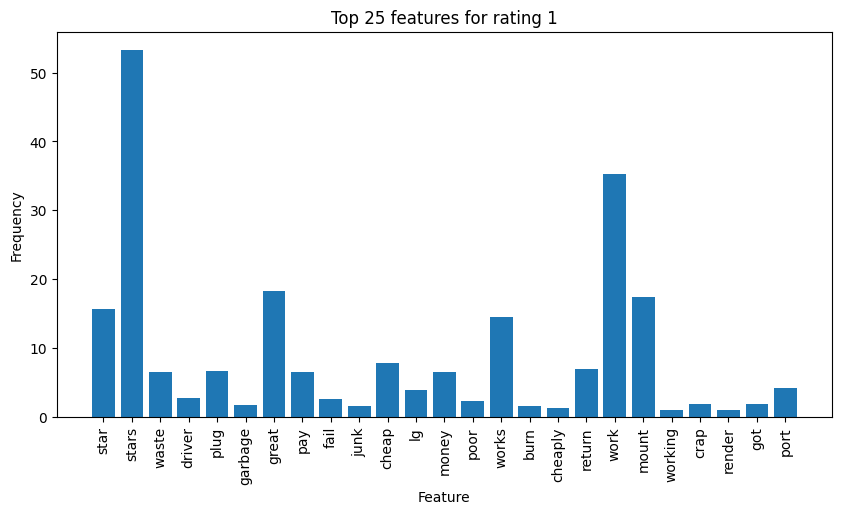

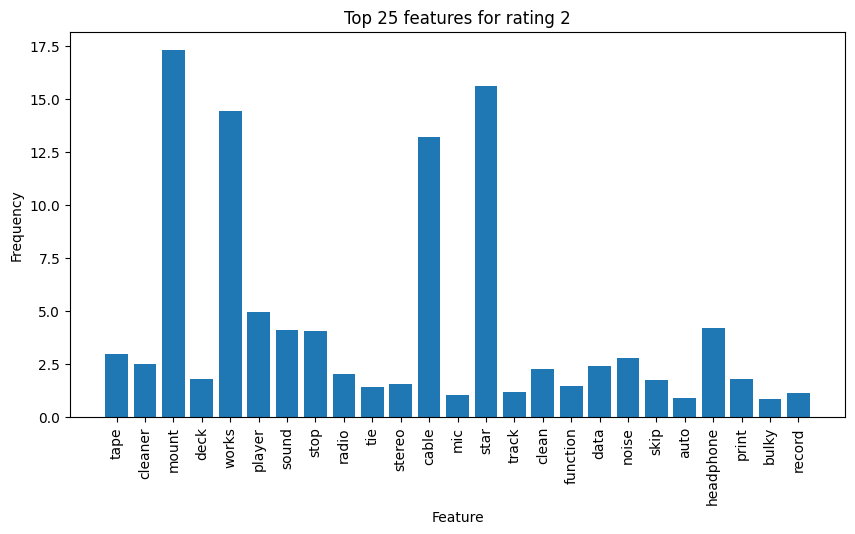

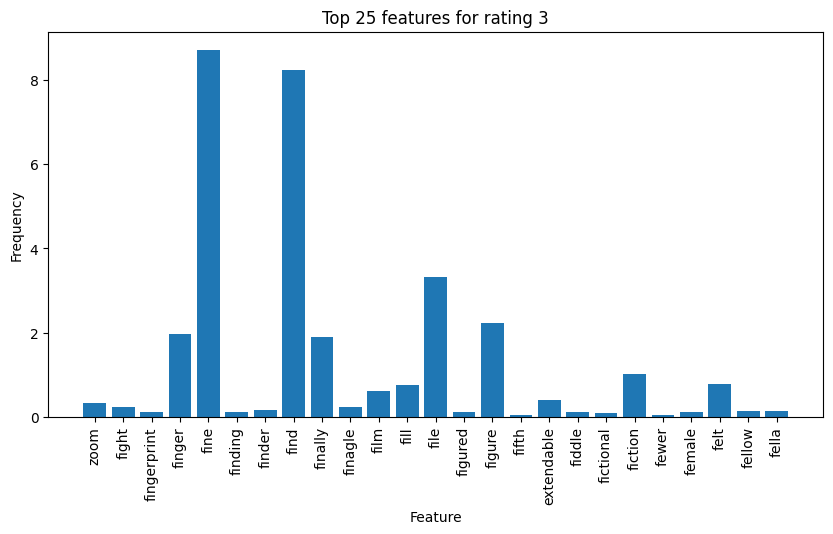

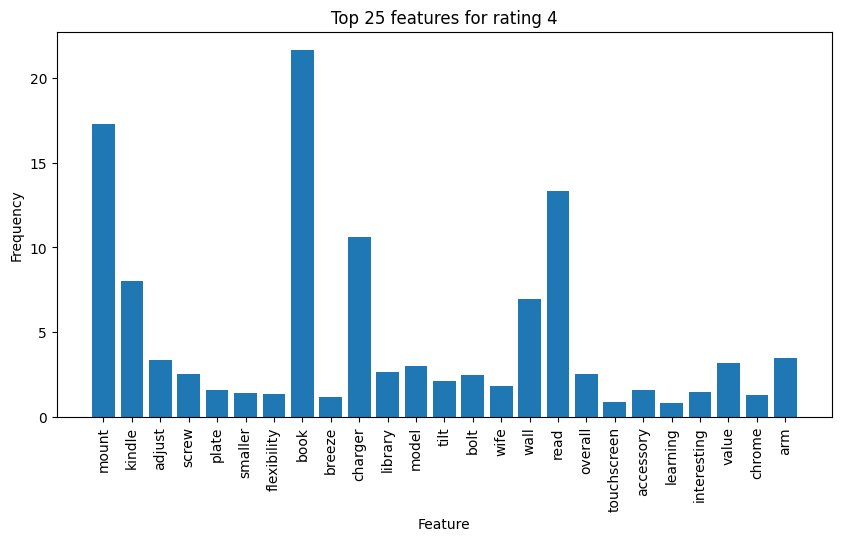

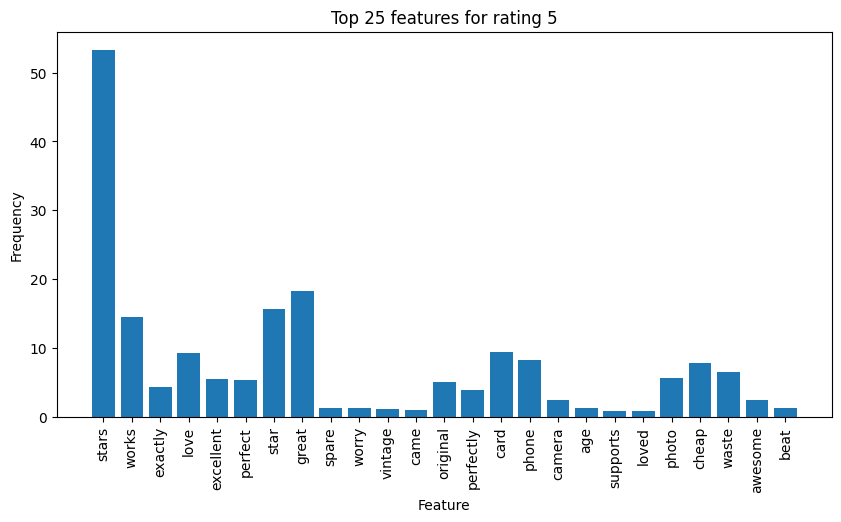

In [70]:
import matplotlib.pyplot as plt

# Create an empty dictionary to store the frequency counts for each label
label_counts = {}

# Loop over each class label
for label in range(1, 6):
    
    # Get the top features for the current label
    top_k_features = top_features[label]
    
    # Create an empty dictionary to store the frequency counts for the top features
    feature_counts = {}
    
    # Loop over each top feature
    for feature in top_k_features:
        
        # Get the frequency count for the current feature
        count = dtm_X_train[feature].sum()
        
        # Add the count to the dictionary
        feature_counts[feature] = count
    
    # Add the feature counts to the dictionary for the current label
    label_counts[label] = feature_counts

# Plot the bar chart for each label
for label, feature_counts in label_counts.items():
    
    # Get the top 25 features and their frequency counts
    features = list(feature_counts.keys())[:25]
    counts = [feature_counts[feature] for feature in features]
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(features, counts)
    ax.set_title(f'Top 25 features for rating {label}')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

# Machine Learning


## Model Training and Tuning

In this step, we trained a Random Forest Classifier with the default paramaters to predict ratings. We also generate a classification report showing the `accuracy`, `precision`, and `recall`, which serves as a comparison point for the model tuning step.

As we can see, the model did an average job at classifying positive and negative reviews. The model classifies the reviews correctly 61 % of the time on average. Other notable results is that while the precision of the classes is about the same; where precision signifies the percentage of the predictions that were the correct for each class, the recall for ratings with 1.0 and 5.0 were the highest. This signifies that the model did the best job at identifying reviews that were very positive or very negative. Specfically, it managed to correctly identify about 70 % of the reviews for those classes.

In [71]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import time

np.random.seed(42) # Set a fixed random seed for reproducibility

rf1 = RandomForestClassifier(random_state=42)

start_time = time.time()

rf1.fit(dtm_X_train, y_train.values.ravel())
dtm_X_val = vectorize(X_val["review"], tfidf_fit)
y_pred = rf1.predict(dtm_X_val) # validate model on validation set

end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

# Print the classification report
print(classification_report(y_val, y_pred)) 

Runtime: 19.276889324188232 seconds
              precision    recall  f1-score   support

         1.0       0.59      0.73      0.65        60
         2.0       0.58      0.42      0.49        60
         4.0       0.62      0.58      0.60        60
         5.0       0.65      0.71      0.68        59

    accuracy                           0.61       239
   macro avg       0.61      0.61      0.60       239
weighted avg       0.61      0.61      0.60       239



In this step, we use Grid search to search through the predefined set of hyperparameters to find the combination of hyperparameters that produces the best results on the validation set. We then output the model with the paramaters that Grid search found to be the best estimator.

Grid search found the best paramaters to be `bootstrap=False`, `min_samples_split=10`, `n_estimators=50`, and `random_state=42`. The classification report generated for the model using these paramaters shows an overall decrease in performance. The accuracy has decreased to 56 %. Additionally, while the precision of the 5.0 star ratings, and the recall of the 4.0 star ratings has marginally increased, there are larger decreases in these metrics for the other classes. In other words, tuning the model had an overall negative impact on the ability to classify reviews.





In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer


rf1 = RandomForestClassifier(random_state=42)
# Define the parameters to search over
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the Grid Search object with 5-fold cross-validation
cv = GridSearchCV(rf1, parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs = -1)

start_time = time.time()

# Fit the Grid Search object on the training data
cv.fit(dtm_X_train, y_train.values.ravel())

# End the timer
end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

best_estimator_rf1 = cv.best_estimator_

y_pred = best_estimator_rf1.predict(dtm_X_val)
print(classification_report(y_val, y_pred))

KeyboardInterrupt: ignored

In this step, we trained a MultiNomial Naive Bayes model with the default paramaters to predict ratings and generated a classification report showing the `accuracy`, `precision`, and `recall`, which serves as a comparison point for the model tuning step.

As we can see, the model did a fairly good job at classifying positive and negative reviews. The model classifies reviews correctly 61 % of the time. Most notably, the model seems to have large differences between precision and recall for most classes, signifying that it is not reliable.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

MNBClassifier = MultinomialNB()

start_time = time.time()

# Train the model using the training data
MNBClassifier.fit(dtm_X_train, y_train.values.ravel())

y_pred = MNBClassifier.predict(dtm_X_val)

# End the timer
end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

# Print the test classification report
print(classification_report(y_val, y_pred))

In this step, we use Grid search to search through the predefined set of hyperparameters to find the combination of hyperparameters that produces the best results on the validation set. We then output the model with the paramaters that Grid search found to be the best estimator.

Suprisingly, tuning the Multinomial Naive Bayes Model also seemed to decrease the performance of the model. The accuracy dropped to 60 %. In general, the tuning seemed to average out the performance of the classifier on all four classes, compared to the default paramaters for the same model. This may make it more reliable.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer


MNBClassifier = MultinomialNB()

# Define parameters to search over
parameters = {
    'alpha': [0.1, 1, 5, 10],
    'fit_prior': [True, False]
}

# Define the Grid Search object with 5-fold cross-validation
mnb = GridSearchCV(MNBClassifier, parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs = -1)

start_time = time.time()

# Fit the Grid Search object on the training data and print the best parameters
mnb.fit(dtm_X_train, y_train.values.ravel())

# End the timer
end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

best_estimator_mnb = mnb.best_estimator_

y_pred = best_estimator_mnb.predict(dtm_X_val)
print(classification_report(y_val, y_pred))


It is also worth noting, that fitting and making predictions using the Random Forest Classifier took noticably longer to run in comparison to the Naive Bayes model.

## Final Model


The model we chose to evaluate on our test set is the tuned Multinomial Naive Bayes model. This model seemed to perform better than the Random Forest Classifer. Additionally, while the accuracy of this model decreased in comparison to the model with default paramaters, we prefered this model as it seemed to classify reviews from all four classes equally.

In [ ]:

start_time = time.time()

best_estimator_mnb.fit(dtm_X_train, y_train.values.ravel())
dtm_X_test = vectorize(X_test["review"], tfidf_fit)
y_pred = best_estimator_mnb.predict(dtm_X_test) # predict on test dataset

# End the timer
end_time = time.time()
# Calculate the runtime
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

# Print the classification report
print(classification_report(y_test, y_pred))

The results of the classificaion report show that the classifier was able to classify reviews correctly 60 % of the time. This is a good sign, as this accuracy is comparable to the accuracy of the model when the it was validated on the validation set. This gives us confidence that the model did not overfit to the data.

Most notably, the model does the best job at classifying reviews that are very positive or very negative. This is shown by the high precision and recall. For example, for the 5.0 star ratings, 67 % of its predictions were correct and it was able to correctly classify 64 % of reviews with a 5.0 star rating. Intuitively, this makes sense, as customers are more likely to use frequently used strong language to express sentiment when they are very satisifed or dissatisfied with a product, which helps in making predictions about the rating they would give.

In summary, the unexpected and surprising results were that tuning the model using Grid search seemed to decrease the performance of both models on the same validation set compared to the models with default paramaters. There are several reasons why this might happen including:


*   The range of the paramaters is not appropriate for the data
*   Insufficient search space



# Conclusion

## Summary of Findings
In conclusion, we were successfully able to build and evaluate a product review classifier based on two machine learning models - Random Forest Classifier and Multinomial Naive Bayes. After finding a dataset to work with, we encountered some data corruption issues which were addressed by reading the file in chunks and removing extraneous features. Our text cleaning function proved to be effective, particularly the spell check step, which significantly improved model performance. Other steps taken within our data preprocessing include the removal of stop words, expansion of contractions, lemmatization, and removal of whitespace, numbers, and non-word characters.


Afterwards, we split the data into training, validation, and test sets, and vectorized the reviews using TFIDF. The initial Random Forest Classifier trained achieved an accuracy of 61%, with the highest precision and recall for the most extreme rating classes (1.0 and 5.0). Grid search tried to identify the best hyperparameters for this model, but resulted in a decrease in accuracy and overall performance.


We also trained a Multinomial Naive Bayes model, which achieved similar results to the Random Forest Classifier, and an accuracy of 61%. Our final model was a Multinomial Naive Bayes model after being tuned using Grid search. Our analysis showed that the models struggled to classify reviews with a rating of 2.0 and 4.0, indicating that our dataset may be biased towards more extreme reviews. Neverthless, we found the overall accuracy of our final model to be promising.

## Real World Implications

In the real world, our model can be applied to automatically classify product reviews as positive or negative - a useful feature from a users perspective due to its ability to help users make more informed purchasing decisions with less effort and time. Companies can also use this information to identify areas of their products that require improvement or areas that are performing well, and take action accordingly. For example, companies could prioritize specific features to improve, or could better highlight key advantages in their marketing to garner increased sales. 


## Project Learnings
The most important and/or surprising thing we learned while working on this project was the importance of thorough preprocessing and the massive impact it has on model accuracy. We also learned that preprocessing takes up a significant amount of time and effort compared to the actual training of the model. Since we were all new to machine learning, we had initially expected and allocated the preprocessing to be trivial and the model training to be time consuming – however, it ended up being the exact opposite. Part of what made the preprocessing challenging included getting the data into a usable format for our machine learning algorithms, and correctly applying preprocessing techniques.

## Next Steps

Some of the potential next steps for this project in the project would include obtaining a larger, less biased dataset, and experimenting with different classification algorithms. Using a larger dataset would likely improve the model's accuracy and generalizability. By experimenting with different algorithms, a reader could gain a better understanding of the strengths and weaknesses of each algorithm and determine which algorithm works best for this particular dataset.

Methods to use feature engineering outputs to influence the model inputs were investigated but not implemented in our final code, thus this is an additional avenue for exploration. While this project used chi-square feature selection to identify important features, there are many other feature engineering techniques that could be explored, such as Principal Component Analysis (PCA), Latent Dirichlet Allocation (LDA), and Word2Vec. By experimenting with different feature engineering techniques, a reader could potentially discover new insights about this dataset.


# Bibliography

1.  Behrooz Noori (2021) Classification of Customer Reviews Using
Machine Learning Algorithms, Applied Artificial Intelligence, 35:8, 567-588, DOI:10.1080/08839514.2021.1922843

2. Li, S., Shu, K., & Liu, H. (2019). Deep learning for sentiment analysis: A survey. Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery, 9(2), e1282. https://doi.org/10.1002/widm.1282

3. M. I. Hossain, M. Rahman, T. Ahmed and A. Z. M. T. Islam, "Forecast the Rating of Online Products from Customer Text Review based on Machine Learning Algorithms," 2021 International Conference on Information and Communication Technology for Sustainable Development (ICICT4SD), Dhaka, Bangladesh, 2021, pp. 6-10, doi: 10.1109/ICICT4SD50815.2021.9396822.

4. Pang, B., & Lee, L. (2008). Opinion mining and sentiment analysis. Foundations and Trends® in Information Retrieval, 2(1-2), 1-135. https://doi.org/10.1561/1500000011


5. Singh, A., & Tucker, C. S. (2017). Customer review networks and the design of new products. Management Science, 63(3), 645-662. https://doi.org/10.1287/mnsc.2015.2403

6. Zhang, Y., Zhou, D., & Wang, X. (2017). Hybrid recommendation with deep sentiment analysis. In Proceedings of the 26th International Joint Conference on Artificial Intelligence (pp. 3062-3068). https://doi.org/10.24963/ijcai.2017/425